# Calibration Procedure

* Compute center offset:
 - Set $\lambda_{\rm center}$ to set of known spectral lines
 - Measure pixel position of each: 
 - average each to determine central pixel $n_o$
 
|   $\lambda_{\rm center}$ | Pixel |           
| ----------------------:  |:------:|
| 0   nm                   | 5.2 | 
| 445 nm                   | 6.22      |  
| 901 nm                   | 3.1      | 


 
* Compute spectrometer calibration angles/length ($\ f_L, \delta, \gamma$)
 * Move known spectral line $\lambda_o$ to left and right sides of detector
 * record $\lambda_{\rm center}$ and pixel position for each 
 * Compute best fit of $\ f_{\rm calib}$


| $\lambda_o$   | Side | $\lambda_{\rm center}$| Pixel  |
| ------------- | ---- |:----------------------|-------:|
| 809.4 nm      | R    |729.4910 nm            |508     |
| 809.4 nm      | L    |899.5830 nm            |  4     |
| ...           | ...  | ...                   |...     |



# Optimization Function

Optimize for 3 parameters:
 * $f_L$: Focal length of spectrometer
 * $\delta$: Detector angle (The angle of the image plane relative to the plane perpendicular to the spectrograph focal axis at the center of the image plane)
 * $\gamma$: inclusion angle

from experiment:
 * $n =  n_{px} - n_o$: Pixel from central pixel
 * $\lambda_{\rm center}$: Wavelength of center pixel 
 * $\lambda_p$: Wavelength of pixel $n$
 
Fixed Constants:
 * $m$: Diffraction order (typically one)
 * $x_{\rm pixel}$: pixel size
 * $d_{grating}$: Grating pitch (1/(groves / mm))
    
residual: (wl,  wl_p, n, f, delta,gamma)

We measure pixel position ($n$) of a known wavelength ($\lambda_p$) for multple peaks and spectrometer positions and find the best fit parameters $\ f_L, \delta, \gamma$:

$$ \lambda_p = f_{\rm calib} ( n,  \lambda_{\rm center}, 
    \underbrace{m, x_{\rm pixel}, d_{\rm grating}}_{\rm spec\ params}, 
    \overbrace{f_L,\ \ \delta,\ \ \gamma}^{\rm Calibration\ params} ) $$

$$ \lambda_p = \frac{d}{m} \cdot \left[ \sin( \psi - \frac{\gamma}{2}) + \sin(\psi+\frac{\gamma}{2} + \eta) \right]$$

Where

$$ \psi = \arcsin \left[ \frac{ m\ \lambda_{\rm center} } { 2\ d_{\rm grating} \cos(\frac{\gamma}{2})} \right] $$

$$ \eta = \arctan \left[ \frac{ n\ x_{pixel} \cos{\delta}} {f_L + n\ x_{pixel} \sin(\delta)} \right]$$

$$n =  n_{px} - n_o$$



In [2]:
from __future__ import division
import numpy as np
import pylab as pl
from pprint import pprint

%matplotlib inline

In [1]:
def wl_p_calib(px, n0, wl_center, m_order, d_grating, x_pixel, f, delta, gamma):
    #consts
    #d_grating = 1./150. #mm
    #x_pixel   = 16e-3 # mm
    #m_order   = 1 # diffraction order, unitless
    n = px - n0

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))

    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta)))

In [3]:
from scipy.optimize import least_squares

def fit_residual(
                # optimization parameters
                (f, delta, gamma,), 
                # other params and data
                px, n0, wl_center, m_order, d_grating, x_pixel,
                wl_actual
                ):
    
    wl_model = wl_p_calib(px, n0, wl_center, m_order, d_grating, x_pixel, f, delta, gamma)
    return wl_model - wl_actual
    
initial_guess = (300, 0, 0)

kwargs = dict(
    px=A, 
    n0=256,
    wl_center=A,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)


# Old Version 

In [ ]:
from lmfit import Parameters, minimize

In [2]:
offset_data = np.array([
[0,     5.1940],
[435.8, 441.0860],
[546.1, 551.3630],
[610.8, 616.2860],
[809.4, 814.4940],
])

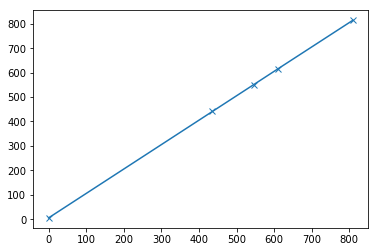

In [3]:
pl.plot(offset_data[:,0], offset_data[:,1], 'x-')

In [5]:
wl_offset = np.average(offset_data[:,0]-offset_data[:,1])
print(wl_offset, "nm")

-5.2646 nm



Dispersion

809.4, R, 508, 729.4910

809.4, L, 004, 899.5830

610.8, R, 508, 531.0920

610.8, L, 004, 701.9610


435.8, R, 508, 354.9880

435.8, L, 004, 526.9880


In [6]:
D = dispersion_data = np.array([
[809.4, 508, 729.4910],
[809.4, 4, 899.5830],
[610.8, 508, 531.0920],
[610.8, 4, 701.9610],
[435.8, 508, 354.9880],
[435.8, 4, 526.9880]
])
data  = dict(
    wl = 1e-6*(D[:,2] + wl_offset),
    n  = D[:,1] - 256,
    wl_p = 1e-6*D[:,0],
)

data

{'n': array([ 252., -252.,  252., -252.,  252., -252.]),
 'wl': array([ 0.00072423,  0.00089432,  0.00052583,  0.0006967 ,  0.00034972,
         0.00052172]),
 'wl_p': array([ 0.0008094,  0.0008094,  0.0006108,  0.0006108,  0.0004358,
         0.0004358])}

In [86]:

def wl_p_func(wl_center, n, f, delta, gamma):
    #consts
    d_grating = 1./150. #mm
    x_pixel   = 16e-3 # mm
    m_order   = 1 # diffraction order, unitless

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))

    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta)))

def residual(wl_center, wl_p, n, f, delta, gamma):

    #print 'wl_center', wl_center.shape
    #print 'psi', psi.shape
    #print 'eta', eta.shape
    
    residual = -wl_p + wl_p_func(wl_center, n, f, delta, gamma)
    return residual


In [90]:
def residual_lmfit(params, x, data):
    f = params['f'].value
    delta = params['delta'].value
    gamma = params['gamma'].value
    
    wl = data['wl']
    wl_p = data['wl_p']
    n = data['n']
    
    return residual(wl, wl_p, n, f, delta, gamma)


params = Parameters()
params.add('f', value=300, vary=True)#, min=280, max=320, vary=True)
params.add('delta', value=0)#, min=-np.pi/8, max=np.pi/8, vary=True)
params.add('gamma', value=np.pi/6)#, min=0, max=np.pi/4, vary=True)


result = minimize(residual_lmfit, params, args=(0,data,))

print result.success, result.message
pprint(params.values())

True Tolerance seems to be too small.
[<Parameter 'f', value=293.49670609146182 +/- 13.6, bounds=[-inf:inf]>,
 <Parameter 'delta', value=0.070372962086993743 +/- 0.134, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=0.62226390460467274 +/- 0.239, bounds=[-inf:inf]>]


In [48]:
180*0.0233/np.pi

1.3349916626548182

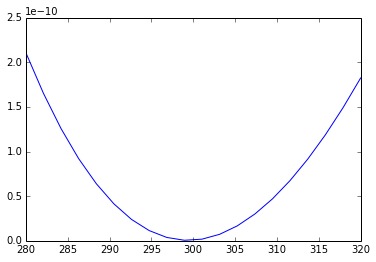

In [79]:
f_array = np.linspace(280,320, 20)
delta = 0
gamma = np.pi/6.
pl.plot(f_array, 
            [np.sum((residual(data['wl'], data['wl_p'], data['n'], 
                              f, delta, gamma))**2)
             for f in f_array])

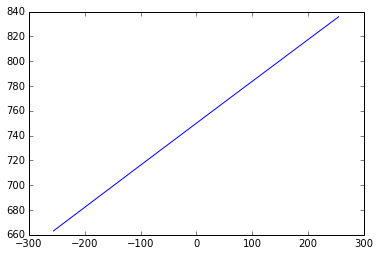

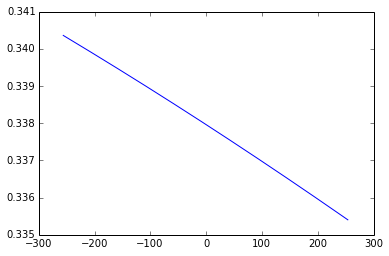

In [76]:
f = params['f'].value
delta = params['delta'].value
gamma = params['gamma'].value

pixels = np.arange(-256,256)
#print wl_p_func(750e-6, pixels, f, delta, gamma)*1e6

pl.plot( pixels, wl_p_func((750e-6, pixels, f, delta, gamma)*1e6)
pl.figure()
pl.plot( pixels[:-1], np.diff(wl_p_func(750e-6, pixels, f, delta, gamma)*1e6))

